# Description

This is notebook contains an example of the usual pipeline used for Deep Learning experiments in this project. More precisely, it contains the cross-validatio results of training a CNN where the feature extractor is a ResNet18 and the header is a feed forward neural net. Oversampling and data augmentation techniques are also applied. Cross validation is used to evaluate the results. Results cannot be replicated, as the used image dataset is not public.

The notebook is structured as follows: 

0. Imports and creation of a folder to store results.
1. Load the dataset on memory, to seed up the trainig process. There's also a Disk version in case the size of the dataset is too much. Check the utilities/dataset/DisckDataset.
2. Define and report hyperparameters.
    - Cross validation. Not strickly an hyperparameter but oversampling and LRFind require it (oversampling is only applied to the train partiton of every split and for LRFind to be effective, the data must the same as the data used durting actual training).
    - Oversampling.
    - Data Transformations.
        - Usual transformations.
        - MixUp.
    - LRFind.
3. Train and validate through cross validation.
4. Evaluation. Corss validation performance.

# 0. Needed

Imports external and own needed funcitonalities.

In [85]:
# Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
from tqdm.auto import tqdm
import utilities.dataset
from torchvision import transforms
import torch
from torchvision import models
from torchsummary import summary
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from utilities.common import specifity_score
from utilities.common import sensitivity_score
from utilities.common import safeMkdir, reproducibility
from utilities.train import train
from utilities.model import SingleLogitResNet
from utilities.loss import BCEL_from_logit_positive_class
from utilities.lrfind import initial_lr_find_Adam
from utilities.mixup import CustomMixUP
from utilities.dataset import RAMDataset

Folder to store results.

In [ ]:
exp_results_dir_path = "../../results/DL_experiment_example"
safeMkdir(f"{exp_results_dir_path}")

# 1. Dataset

RAMDataset allows to load the dataset images already preprocessde in memory to speed up the training process. RAMDataset constructor requires a Pandas Data Frame containing one row per image where the image path and the image label to do so. For simplicity, this frame was previously created during the early stages of the project (data exploration). This frame ONLY includes only the train-validation samples, so no test partition is neeeded.

,ID,DATE BIRTH,DATE RX,SEX,età,# Mouth Images,# Wrist Images,Mouth Images Names,Wrist Images Names,¿Adulto?
0,2,1991-12-23,2003-04-08,M,11.298630,1,1,../../Data South Africa/Black xrays\2.JPG,../../Data South Africa/black South African ha...,0
1,3,1991-11-22,2000-11-16,F,8.991781,1,1,../../Data South Africa/Black xrays\3.JPG,../../Data South Africa/black South African ha...,0
2,4,1989-04-04,2002-12-10,F,13.693151,1,1,../../Data South Africa/Black xrays\4 .JPG,../../Data South Africa/black South African ha...,0
3,6,2002-12-14,2014-06-18,M,11.517808,1,1,../../Data South Africa/Black xrays\6 .JPG,../../Data South Africa/black South African ha...,0
4,7,2002-05-14,2011-02-18,M,8.772603,1,0,../../Data South Africa/Black xrays\7.JPG,NaN,0
...,...,...,...,...,...,...,...,...,...,...
1389,2265,1994-05-25,2009-01-08,M,14.635616,1,0,../../Data South Africa/Black xrays\2265 tsela...,NaN,0
1390,2267,2006-09-18,2014-07-02,M,7.791781,1,0,../../Data South Africa/Black xrays\2267.jpg,NaN,0
1391,2268,2005-10-02,2012-10-02,M,7.005479,1,0,../../Data South Africa/Black xrays\2268.jpg,NaN,0
1392,2269,2002-08-03,2013-06-28,F,10.909589,1,0,../../Data South Africa/Black xrays\2269.jpg,NaN,0


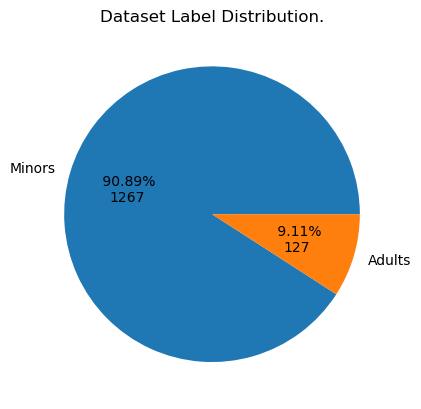

In [4]:
# Train-Validation Data Frame
data_path = f'../data/trainval_df.csv'
dataset_df = pd.read_csv(data_path)
# Display Frame
display.display(dataset_df)
# Plot label distribution
num_menores = len(dataset_df.loc[dataset_df['¿Adulto?']==0])
num_adultos = len(dataset_df.loc[dataset_df['¿Adulto?']==1])
fig, axs = plt.subplots(1, 1)
fig.set_facecolor("w")
fig.set_figheight(fig.get_figheight()*1)
fig.set_figwidth(fig.get_figwidth()*1)
axs.pie(
    [num_menores, num_adultos], 
    labels=['Minors', 'Adults'], 
    autopct=lambda p: f' {p:.2f}%\n{p*(num_menores+num_adultos)/100:.0f}',
    )
axs.set_title("Dataset Label Distribution.")
plt.show()

To speed up the training process, pre-processing transformations are applied before hand so, they must be already defined.

In [5]:
# Pre-procesing transformations
transformations = transforms.Compose(
        [
        # Internally, images are opned as PIL.Image's 
        # Trasnform PIL.Image (int8 in [0, 255]) --> Pytorch.Tensor (float32 in [0.0, 1.0]).
        transforms.ToTensor(),
        # Changes the dimensions of the image.
        transforms.Resize(
            size = [224,224],
            interpolation = transforms.InterpolationMode.BILINEAR,
            max_size = None,
            antialias=False #'warn'
            ),
        # Normalize based on ImageNet metrics
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

Actual loading of the data.

In [6]:
# Loading the images to memory
ram_dataset = RAMDataset(
    metadata_df             = dataset_df, 
    path_col                = 'Mouth Images Names', 
    label_col               = '¿Adulto?',
    transforms              = transformations,
    verbose                 = True,
)

Loading/Transforming Images:   0%|          | 0/1394 [00:00<?, ?it/s]

# 2. Hyperpameters

Now, we define the hyperparameters:
- Seeds for random pseudoprocesses.
- Maximum number of epochs.
- Batch size.
- Early Stopping.
    - Metric.
    - Patience.
    - Tolerance.
- Loss function.
- Model Architecture.
- EXTRA: Cross Validation indexes.
- Oversampling.
- Learning Rate.
- Data Augmentation techniques.
    - "Basic" = Applicable to a single iamge = Rotations and Translations.
        - Which labels to apply to.
        - Probability of the transformation or proportion of transformed images.
    - "Complex" = Need two images to apply it = MixUp.
        - $\alpha_{MU}$.
        - First or before "basic" transformations.

## Miscelaneus

In [101]:
# --------------- Reproducibility ---------------
torch_seed  =   1234 # Initial values, batching ordes
skf_seed    =   1234 # 5-Fold-Cross-Validation indexes
# --------------- Number of epochs ---------------
n_epochs = 50
# --------------- Batch Size ---------------
batch_size = 32
# --------------- Early Stopping ---------------
es_tolerance = 0.01
es_patience = 10
es_metric = 'loss'
# --------------- Best Model Evaluation ---------------
bm_metric = es_metric

## Loss Function

In [102]:
# --------------- Loss Function ---------------
loss = BCEL_from_logit_positive_class(reduction='mean')

## Architecture

In [103]:
# Reproducible initial values
reproducibility(seed=torch_seed) # Initial values
fe = models.resnet18(weights='IMAGENET1K_V1')
resnet = SingleLogitResNet(resnet=fe)

# Frozen/Unfrozen parameters
for param in resnet.feature_extractor.parameters():
  param.requires_grad = False
for param in resnet.fc_head.parameters():
  param.requires_grad = True
model = resnet.to("cuda")
num_parameters = sum([p.numel() for p in model.parameters()])
num_parameters_unfrozen = sum([p.numel() for p in model.parameters() if p.requires_grad])

# Saving Model
with open(f"{exp_results_dir_path}/model.txt", "w") as f:
    f.write(str(summary(model=resnet, input_data=(3,224,224), verbose=False)))

#  Saving Initial Values
torch.save(resnet.state_dict(), f'{exp_results_dir_path}/initial_values.pt')

### Partial Report

In [104]:
# Reporting hyperparameters
with open(f"{exp_results_dir_path}/report.txt", "w") as f:
    f.write(f"- PyTorch Seed (used for initial values and batching) = {torch_seed}" + '\n')
    f.write(f"- K-Fold Seed (used for generating partitions) = {skf_seed}" + '\n')
    f.write(f"- Number of total params = {num_parameters}" + '\n')
    f.write(f"- Number of trainable params = {num_parameters_unfrozen}" + '\n')
    f.write(f"- Batch Size = {batch_size}" + '\n')
    f.write(f"- Number of Epochs = {n_epochs}" + '\n')
    f.write(f"- Loss = {loss} \n\t- Reduction Method = {loss.reduction}" + '\n')
    f.write(f"- Early Stopping = \n\t- Tolerance = {es_tolerance}\n\t- Patience = {es_patience}\n\t- Metric = {es_metric}\n")
    f.write(f"- Dataset Original Length = {len(ram_dataset.imgs)}\n")
    f.write(f"- Image Pre-processing = {ram_dataset.transforms}\n")

## Cross Validation Partition

Cross validation could not be considered a hyperparameter. In that case, including this step here wouldn't make sense. However, indexes used for every train-validation split are needed in order to apply oversampling only to the train partition of every split. Oversampling is also needed before executing LR-Find to set the learing rate.

An index refers to which image use during training. This index matches the row of the image in the initial data frame.

Partition 0:
	- # train samples = 1115 = 0.80 %
		 - # positives = 102 = 0.09 %
		 - # negatives = 1013 = 0.91 %
	- # validation samples = 279 = 0.20 %
		 - # positives = 25 = 0.09 %
		 - # negatives = 254 = 0.91 %


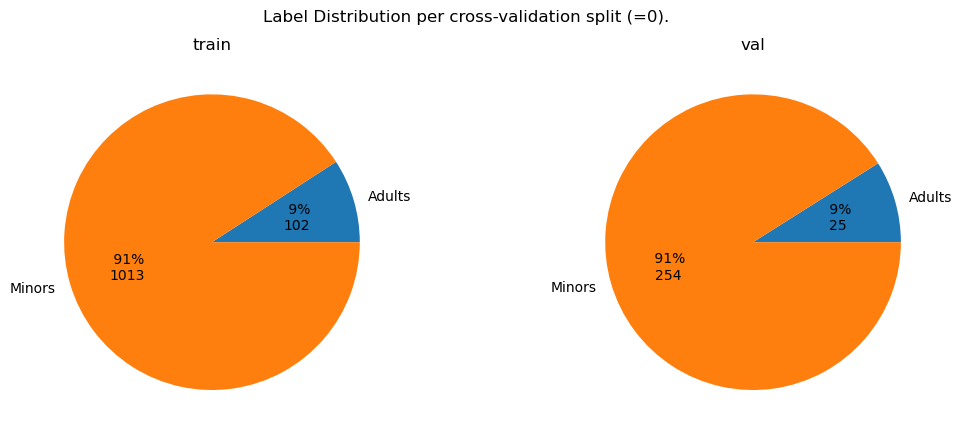

In [105]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=skf_seed)
# i-th element contain de train indices for the i-th partition
train_idxs = [train_idxs for train_idxs, _ in kf.split(X=np.zeros(len(ram_dataset)), y=ram_dataset.labels)]
# i-th element contain de validation indices for the i-th partition
val_idxs = [val_idxs for _, val_idxs in kf.split(X=np.zeros(len(ram_dataset)), y=ram_dataset.labels)]

for k, (train_idxs_for_k, val_idxs_for_k) in enumerate(zip(train_idxs, val_idxs)):
    # Train Label Distribution
    train_n_positives = len((ram_dataset.labels[train_idxs_for_k] == 1).nonzero().squeeze())
    train_n_negatives = len((ram_dataset.labels[train_idxs_for_k] == 0).nonzero().squeeze())
    val_n_positives = len((ram_dataset.labels[val_idxs_for_k] == 1).nonzero().squeeze())
    val_n_negatives = len((ram_dataset.labels[val_idxs_for_k] == 0).nonzero().squeeze())
    print(f"Partition {k}:")
    print(f"\t- # train samples = {len(train_idxs_for_k)} = {len(train_idxs_for_k)/(len(train_idxs_for_k)+len(val_idxs_for_k)):0.2f} %")
    print("\t\t - # positives = {} = {:0.2f} %".format(train_n_positives, train_n_positives/len(train_idxs_for_k)))
    print("\t\t - # negatives = {} = {:0.2f} %".format(train_n_negatives, train_n_negatives/len(train_idxs_for_k)))
    print(f"\t- # validation samples = {len(val_idxs_for_k)} = {len(val_idxs_for_k)/(len(train_idxs_for_k)+len(val_idxs_for_k)):0.2f} %")
    print("\t\t - # positives = {} = {:0.2f} %".format(val_n_positives, val_n_positives/len(val_idxs_for_k)))
    print("\t\t - # negatives = {} = {:0.2f} %".format(val_n_negatives, val_n_negatives/len(val_idxs_for_k)))
    
    # Visualizse
    p_train = [train_n_positives, train_n_negatives]
    p_val = [val_n_positives, val_n_negatives]
    fig, axs = plt.subplots(1, 2)
    fig.set_facecolor("w")
    fig.set_figheight(fig.get_figheight()*1)
    fig.set_figwidth(fig.get_figwidth()*2)
    for i, prop in enumerate(zip([p_train, p_val], ['train', 'val'])):
        axs[i].pie(
            [prop[0][0], prop[0][1]], 
            labels=['Adults', 'Minors'], 
            autopct=lambda p: f' {p:.0f}%\n{p*(prop[0][0]+prop[0][1])/100:.0f}',
            )
        axs[i].set_title(f'{prop[1]}')
    fig.suptitle('Label Distribution per cross-validation split (={}).'.format(k), fontsize=12)
    plt.show()
    break

## Oversampling

Oversampling algorithm: Duplicate aults images until eaching the same number of adults and childs. Once an image is duplicated for the i-th time, the image is not elegible again until all the rest of adult images are duplicated i times. Random oversampling with no replacement repeated until having the same number of instances of the both classes. 

Inorder to save memory, iamges are not actually duplicated, indices used during training and validation pointing to those images are.

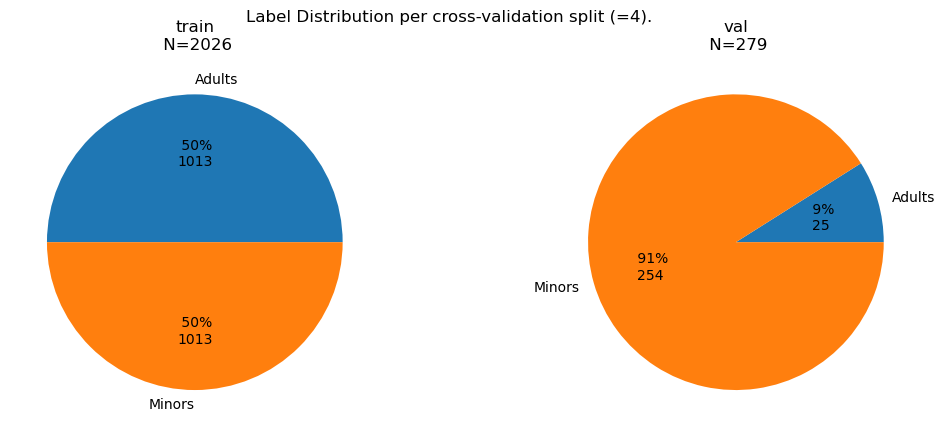

In [106]:
for k, train_idxs_for_k in enumerate(train_idxs):
    train_pos = dataset_df.iloc[train_idxs_for_k].loc[dataset_df['¿Adulto?']==1]
    train_neg = dataset_df.iloc[train_idxs_for_k].loc[dataset_df['¿Adulto?']==0]
    # Oversampling algorithm
    new_train_idxs = np.hstack((
        train_neg.index.to_numpy(), 
        *[train_pos.index.to_numpy() for i in range(len(train_neg)//len(train_pos))],
        train_pos.sample(n=len(train_neg)-int(len(train_neg)//len(train_pos))*len(train_pos), random_state=skf_seed).index.to_numpy()
    ))
    train_idxs[k] = new_train_idxs
    
# Visualización
for split in range(5):
    p_train = [len(dataset_df.iloc[train_idxs[split]].loc[(dataset_df['¿Adulto?'] == 1)]), len(dataset_df.iloc[train_idxs[split]].loc[(dataset_df['¿Adulto?'] == 0)])]
    p_val = [len(dataset_df.iloc[val_idxs[split]].loc[(dataset_df['¿Adulto?'] == 1)]), len(dataset_df.iloc[val_idxs[split]].loc[(dataset_df['¿Adulto?'] == 0)])]
    fig, axs = plt.subplots(1, 2)
    fig.set_facecolor("w")
    fig.set_figheight(fig.get_figheight()*1)
    fig.set_figwidth(fig.get_figwidth()*2)
    for i, prop in enumerate(zip([p_train, p_val], ['train', 'val'])):
        axs[i].pie(
            [prop[0][0], prop[0][1]], 
            labels=['Adults', 'Minors'], 
            autopct=lambda p: f' {p:.0f}%\n{p*(prop[0][0]+prop[0][1])/100:.0f}',
            )
        title = (lambda x: 'train' if (prop[1] == 'train') else "val")(prop[1])
        n = prop[0][0]+prop[0][1]
        title += f"\n N={n}"
        axs[i].set_title(title)
    fig.suptitle('Label Distribution per cross-validation split (={}).'.format(k), fontsize=12)
    plt.show()
    break

## Data Transformations

Two kind of transformations where applied: some could only be applied to one image at a time, called "basic" trasnformations (transformations and translations) and some needed the whole batch of images called "complex" transformations (MixUp).

For "basic" transformations, the transformation for every class can be different, that's why it is specified as a dictionary, where every key matches a possible class and every value the transformations applied to that class.

For more information on transformations, check: https://pytorch.org/vision/stable/transforms.html.

In [107]:
# Simple transformations, in this case, only a rotation of 90, 180 or 270 applied to both classes.
data_augmentation_t = {
    0:v2.RandomApply([
            v2.RandomChoice([
                v2.RandomRotation(degrees=[90, 90], interpolation=v2.InterpolationMode.NEAREST),
                v2.RandomRotation(degrees=[180, 180], interpolation=v2.InterpolationMode.NEAREST),
                v2.RandomRotation(degrees=[270, 270], interpolation=v2.InterpolationMode.NEAREST),
            ])
        ],
        p = 0.5
    ),
    1:v2.RandomApply([
            v2.RandomChoice([
                v2.RandomRotation(degrees=[90, 90], interpolation=v2.InterpolationMode.NEAREST),
                v2.RandomRotation(degrees=[180, 180], interpolation=v2.InterpolationMode.NEAREST),
                v2.RandomRotation(degrees=[270, 270], interpolation=v2.InterpolationMode.NEAREST),
            ])
        ],
        p = 0.5
    ),
}
with open(f"{exp_results_dir_path}/report.txt", "a") as f:
    f.write(f"\n- Data Augmentation: \n\t*Transformation = {data_augmentation_t}" + '\n')

In [108]:
# MixUp
# --> alpha_mu = 0.1 
# --> Applied before the rest of transformations.
mixup_t = CustomMixUP(alpha=0.1)
mixup_t.first = True
with open(f"{exp_results_dir_path}/report.txt", "a") as f:
    f.write(f"\n- MixUp: " + str(mixup_t) + f"\n\t* First = {mixup_t.first}" + '\n')

## LR-Find

In [109]:
# Folder to store results
safeMkdir(f"{exp_results_dir_path}/lr_find")

# Re-instatntiate the model
reproducibility(seed=1234) # Batching
resnet.load_state_dict(torch.load(f'{exp_results_dir_path}/initial_values.pt')) # Initial values

# lr-find
min_exp = -10
max_exp = 0
n_iters = 1000
lres, lrs, losses = utilities.lrfind.initial_lr_find_Adam(
   model=resnet,
   loss=loss,
   dataloader=DataLoader(
       torch.utils.data.Subset(ram_dataset, train_idxs[0]), 
       batch_size=batch_size, shuffle=True)
       , # Using partition 0 training samples
   min_exp=min_exp,
   max_exp=max_exp,
   n_iters=n_iters,
   save_path=f'{exp_results_dir_path}/lr_find/lr_find_results.csv',
   data_augmentation_t = data_augmentation_t,
   mixup_t = mixup_t
)

LR-Finder Progress:   0%|          | 0/1000 [00:00<?, ?lr_candidate/s]

Let's visualize the results as curve to choose an appropiate 

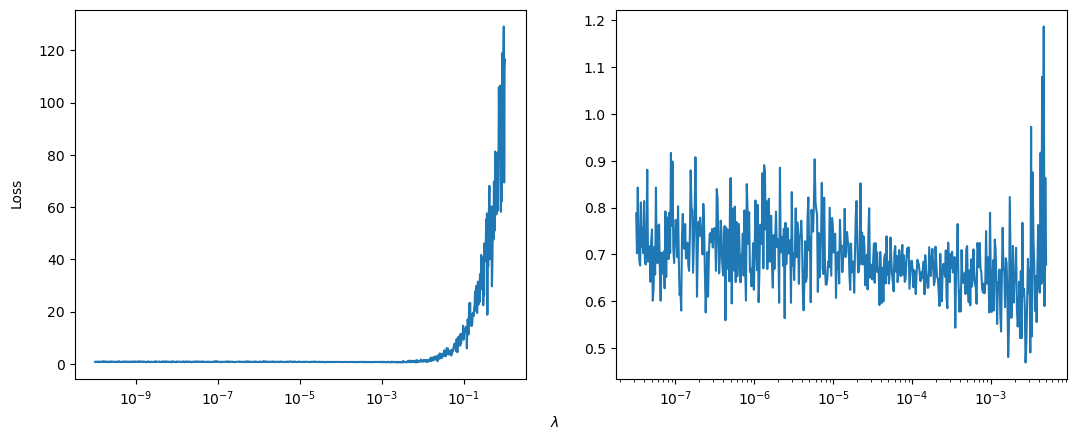

In [110]:
# VIsualizing results
fig, axs = plt.subplots(1, 2)
fig.set_facecolor("w")
fig.set_figheight(fig.get_figheight()*1)
fig.set_figwidth(fig.get_figwidth()*2)
axs[0].plot(lrs[:], losses[:])
axs[0].set_xscale('log')
axs[1].plot(lrs[250:-230], losses[250:-230])
axs[1].set_xscale('log')
fig.text(0.5, 0.02, '$\\lambda$', ha='center', va='center')
fig.text(0.08, 0.5, 'Loss', ha='center', va='center', rotation='vertical')
plt.savefig(f'{exp_results_dir_path}/lr_find/plots.png')
plt.show()

$\lambda = 1 \cdot 10^{-4}$ seems like an approiate value.

In [111]:
# Optimizer
lr = 1e-4
optimizer = torch.optim.Adam(
    [
        {"params": resnet.fc_head.parameters(), "lr": lr},
    ],
)
with open(f"{exp_results_dir_path}/report.txt", "a") as f:
    f.write(f"- Optimizer = {optimizer}" + '\n')

# 3. Training and Validation

Instead of using the defaul evaulation metrics (loss, acc, sen, spe an), we also add f1-score. Any custom function that admits two parameters, one being the true labels an other being the predicted labels, and returns a float number, could be used.

In [112]:
metrics : dict ={
        'acc':accuracy_score,
        'sen':sensitivity_score,
        'spe':specifity_score,
        'f1':f1_score,
        'cm':confusion_matrix
    }

 ------------ Partition 0: ------------
Training ...
EARLY STOPPING. Metric = 'val_loss'. Patience = 10. Tolerance = 0.01.
STORING BEST MODEL FOR 'val_loss' AT ../results/experiment_example/partition_0/best_model_params.pt .


Training Progress:   0%|          | 0/50 [00:00<?, ?epoch/s]

,train_loss,train_acc,train_sen,train_spe,train_f1,train_cm,val_loss,val_acc,val_sen,val_spe,val_f1,val_cm,epoch_time
0,0.655443,0.564166,0.649123,0.530907,0.455946,"[[773, 683], [200, 370]]",0.674571,0.566308,0.52,0.570866,0.176871,"[[145, 109], [12, 13]]",13.555791
1,0.645878,0.557749,0.660312,0.516908,0.459590,"[[749, 700], [196, 381]]",0.666061,0.569892,0.64,0.562992,0.210526,"[[143, 111], [9, 16]]",13.625285
2,0.632541,0.526654,0.759857,0.438011,0.469286,"[[643, 825], [134, 424]]",0.693017,0.526882,0.72,0.507874,0.214286,"[[129, 125], [7, 18]]",12.957561
3,0.625768,0.553307,0.689338,0.503374,0.453172,"[[746, 736], [169, 375]]",0.653990,0.598566,0.72,0.586614,0.243243,"[[149, 105], [7, 18]]",13.458904
4,0.621919,0.564659,0.770833,0.482759,0.501695,"[[700, 750], [132, 444]]",0.667974,0.602151,0.76,0.586614,0.255034,"[[149, 105], [6, 19]]",13.330700
5,0.614109,0.622409,0.572202,0.641304,0.453181,"[[944, 528], [237, 317]]",0.555043,0.741935,0.48,0.767717,0.250000,"[[195, 59], [13, 12]]",13.460515
6,0.606199,0.571076,0.683363,0.528289,0.467851,"[[775, 692], [177, 382]]",0.611885,0.666667,0.64,0.669291,0.256000,"[[170, 84], [9, 16]]",13.292077
7,0.607658,0.580948,0.715771,0.527260,0.493134,"[[764, 685], [164, 413]]",0.614069,0.666667,0.68,0.665354,0.267717,"[[169, 85], [8, 17]]",12.992251
8,0.590889,0.573050,0.815552,0.482010,0.510470,"[[710, 763], [102, 451]]",0.654068,0.587814,0.80,0.566929,0.258065,"[[144, 110], [5, 20]]",13.251673
9,0.592270,0.573544,0.763016,0.501702,0.495916,"[[737, 732], [132, 425]]",0.634486,0.623656,0.76,0.610236,0.265734,"[[155, 99], [6, 19]]",13.050724


TRAINING STOPED BY EARLY-STOPPING AT EPOCH 26. NO SIGNIFICANT IMPORVEMENT (tolerance=0.01) ON 'val_loss' SINCE EPOCH 15.
LOADED BEST MODEL FOR 'val_loss' FOUND AT EPOCH 15 FROM ../results/experiment_example/partition_0/best_model_params.pt .


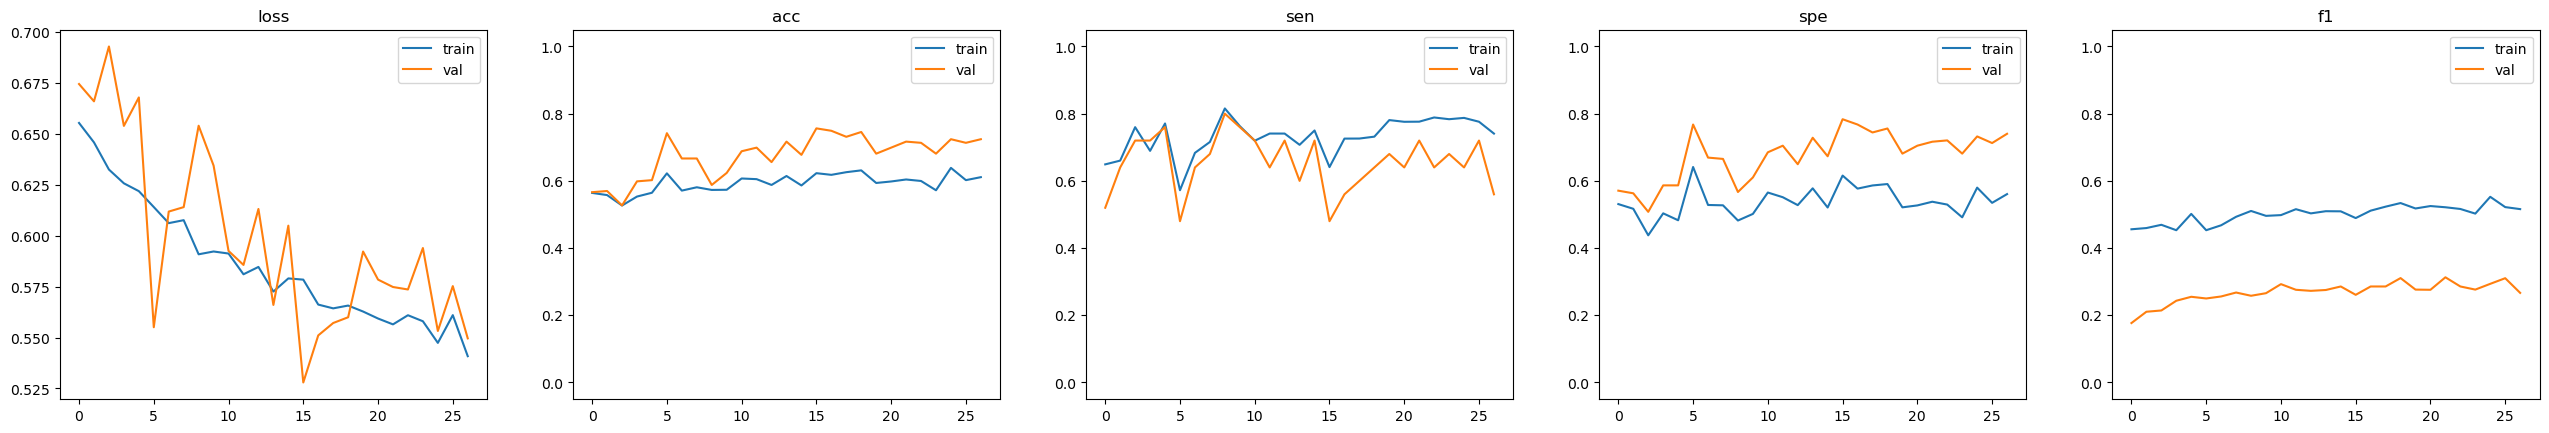

 ------------ Partition 1: ------------
Training ...
EARLY STOPPING. Metric = 'val_loss'. Patience = 10. Tolerance = 0.01.
STORING BEST MODEL FOR 'val_loss' AT ../results/experiment_example/partition_1/best_model_params.pt .


Training Progress:   0%|          | 0/50 [00:00<?, ?epoch/s]

,train_loss,train_acc,train_sen,train_spe,train_f1,train_cm,val_loss,val_acc,val_sen,val_spe,val_f1,val_cm,epoch_time
0,0.667706,0.532083,0.656140,0.483516,0.441038,"[[704, 752], [196, 374]]",0.680168,0.534050,0.72,0.515748,0.216867,"[[131, 123], [7, 18]]",13.082016
1,0.655095,0.542448,0.667244,0.492754,0.453742,"[[714, 735], [192, 385]]",0.676793,0.566308,0.68,0.555118,0.219355,"[[141, 113], [8, 17]]",13.487291
2,0.648467,0.506910,0.709677,0.429837,0.442211,"[[631, 837], [162, 396]]",0.694917,0.548387,0.80,0.523622,0.240964,"[[133, 121], [5, 20]]",12.968196
3,0.638713,0.527641,0.685662,0.469636,0.438050,"[[696, 786], [171, 373]]",0.673687,0.569892,0.72,0.555118,0.230769,"[[141, 113], [7, 18]]",13.567408
4,0.638556,0.574531,0.689236,0.528966,0.479469,"[[767, 683], [179, 397]]",0.663594,0.569892,0.72,0.555118,0.230769,"[[141, 113], [7, 18]]",13.520183
5,0.630033,0.616486,0.530686,0.648777,0.430769,"[[955, 517], [260, 294]]",0.550790,0.731183,0.48,0.755906,0.242424,"[[192, 62], [13, 12]]",13.469305
6,0.627922,0.577986,0.620751,0.561691,0.448031,"[[824, 643], [212, 347]]",0.618214,0.645161,0.60,0.649606,0.232558,"[[165, 89], [10, 15]]",13.149793
7,0.622087,0.564659,0.691508,0.514148,0.475000,"[[745, 704], [178, 399]]",0.642208,0.594982,0.64,0.590551,0.220690,"[[150, 104], [9, 16]]",13.453107
8,0.608535,0.556269,0.730561,0.490835,0.473345,"[[723, 750], [149, 404]]",0.659683,0.580645,0.72,0.566929,0.235294,"[[144, 110], [7, 18]]",13.234835
9,0.611358,0.581441,0.707361,0.533696,0.481663,"[[784, 685], [163, 394]]",0.642654,0.609319,0.68,0.602362,0.237762,"[[153, 101], [8, 17]]",13.355166


TRAINING STOPED BY EARLY-STOPPING AT EPOCH 16. NO SIGNIFICANT IMPORVEMENT (tolerance=0.01) ON 'val_loss' SINCE EPOCH 5.
LOADED BEST MODEL FOR 'val_loss' FOUND AT EPOCH 15 FROM ../results/experiment_example/partition_1/best_model_params.pt .


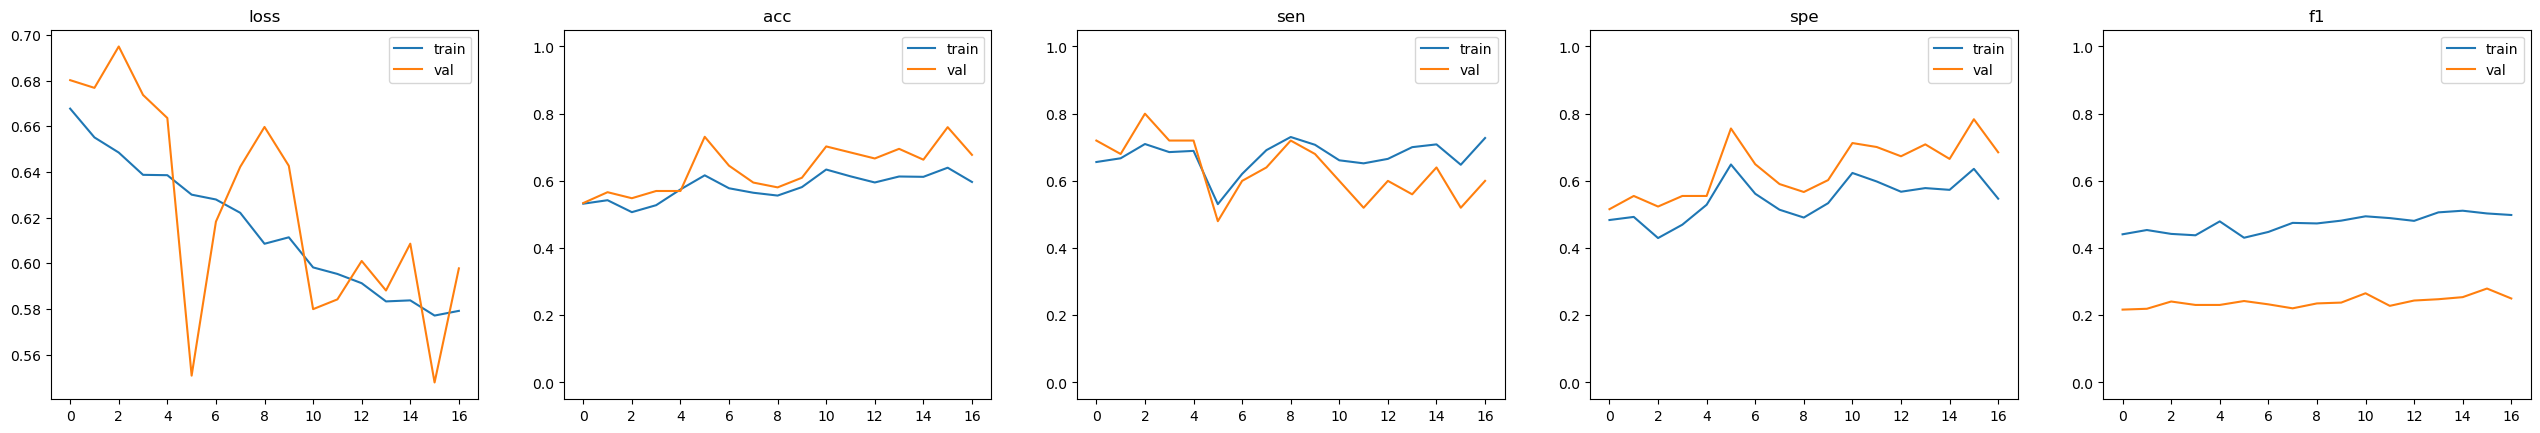

 ------------ Partition 2: ------------
Training ...
EARLY STOPPING. Metric = 'val_loss'. Patience = 10. Tolerance = 0.01.
STORING BEST MODEL FOR 'val_loss' AT ../results/experiment_example/partition_2/best_model_params.pt .


Training Progress:   0%|          | 0/50 [00:00<?, ?epoch/s]

,train_loss,train_acc,train_sen,train_spe,train_f1,train_cm,val_loss,val_acc,val_sen,val_spe,val_f1,val_cm,epoch_time
0,0.660889,0.589250,0.548276,0.605663,0.432948,"[[877, 571], [262, 318]]",0.655006,0.627240,0.615385,0.628458,0.235294,"[[159, 94], [10, 16]]",13.578699
1,0.641428,0.541420,0.752137,0.455994,0.486188,"[[658, 785], [145, 440]]",0.716129,0.476703,0.730769,0.450593,0.206522,"[[114, 139], [7, 19]]",13.481523
2,0.632339,0.577909,0.712565,0.523842,0.491686,"[[758, 689], [167, 414]]",0.678689,0.516129,0.730769,0.494071,0.219653,"[[125, 128], [7, 19]]",13.548680
3,0.623827,0.586292,0.653240,0.560055,0.470662,"[[816, 641], [198, 373]]",0.649515,0.573477,0.615385,0.569170,0.211921,"[[144, 109], [10, 16]]",13.470138
4,0.623909,0.591716,0.627178,0.577717,0.465116,"[[840, 614], [214, 360]]",0.631974,0.612903,0.615385,0.612648,0.228571,"[[155, 98], [10, 16]]",13.463918
5,0.613639,0.617357,0.659381,0.601758,0.482667,"[[890, 589], [187, 362]]",0.636757,0.616487,0.615385,0.616601,0.230216,"[[156, 97], [10, 16]]",13.552713
6,0.607298,0.571006,0.701031,0.518672,0.483986,"[[750, 696], [174, 408]]",0.661337,0.562724,0.653846,0.553360,0.217949,"[[140, 113], [9, 17]]",13.489886
7,0.602383,0.563116,0.731959,0.495159,0.490219,"[[716, 730], [156, 426]]",0.684899,0.544803,0.730769,0.525692,0.230303,"[[133, 120], [7, 19]]",13.210714
8,0.603443,0.582840,0.773913,0.507226,0.512673,"[[737, 716], [130, 445]]",0.678649,0.541219,0.730769,0.521739,0.228916,"[[132, 121], [7, 19]]",13.617322
9,0.590882,0.626233,0.704626,0.596180,0.510968,"[[874, 592], [166, 396]]",0.611123,0.637993,0.653846,0.636364,0.251852,"[[161, 92], [9, 17]]",13.395208


LOADED BEST MODEL FOR 'val_loss' FOUND AT EPOCH 41 FROM ../results/experiment_example/partition_2/best_model_params.pt .


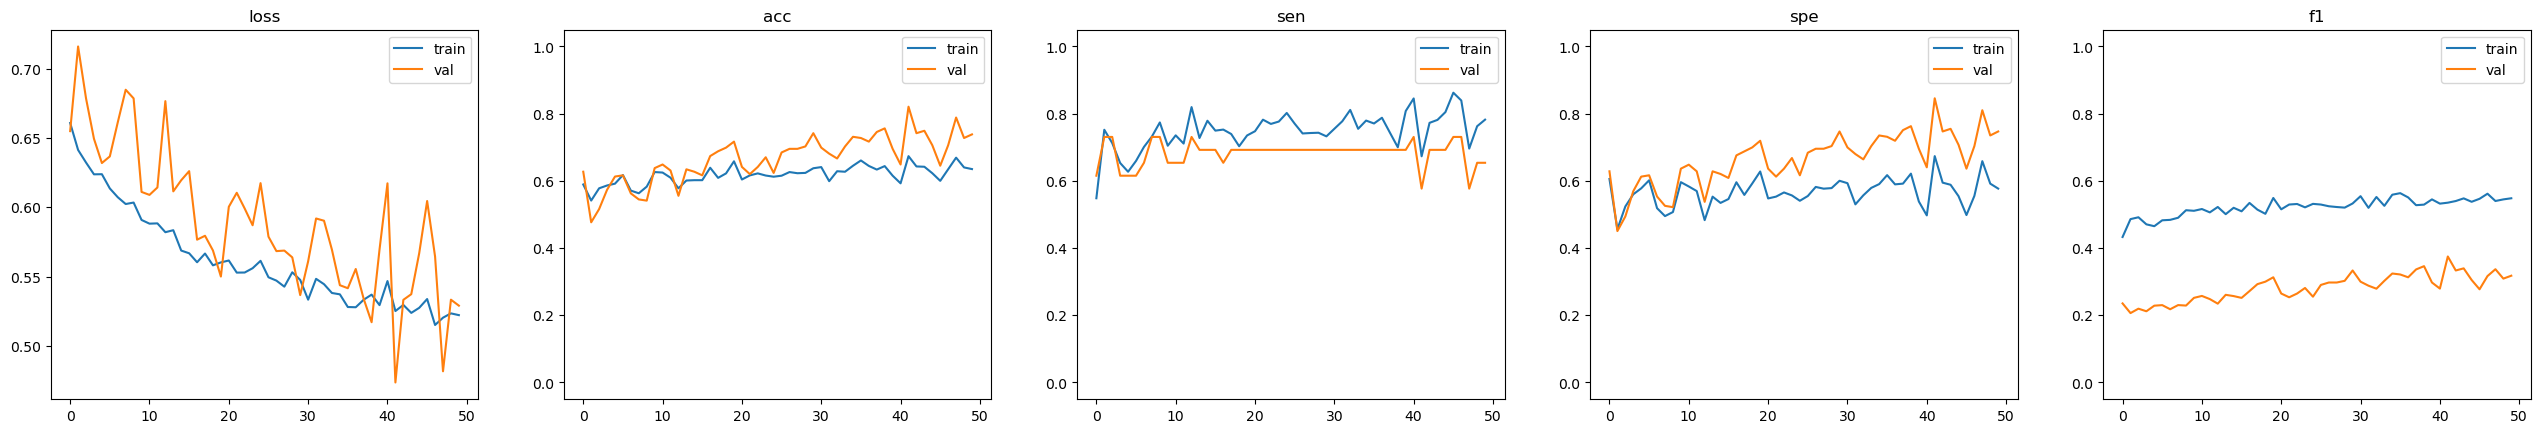

 ------------ Partition 3: ------------
Training ...
EARLY STOPPING. Metric = 'val_loss'. Patience = 10. Tolerance = 0.01.
STORING BEST MODEL FOR 'val_loss' AT ../results/experiment_example/partition_3/best_model_params.pt .


Training Progress:   0%|          | 0/50 [00:00<?, ?epoch/s]

,train_loss,train_acc,train_sen,train_spe,train_f1,train_cm,val_loss,val_acc,val_sen,val_spe,val_f1,val_cm,epoch_time
0,0.668040,0.536489,0.558621,0.527624,0.408060,"[[764, 684], [256, 324]]",0.656259,0.598566,0.615385,0.596838,0.222222,"[[151, 102], [10, 16]]",12.219410
1,0.646403,0.547830,0.688889,0.490644,0.467789,"[[708, 735], [182, 403]]",0.663427,0.551971,0.653846,0.541502,0.213836,"[[137, 116], [9, 17]]",11.863101
2,0.645290,0.548817,0.707401,0.485142,0.473230,"[[702, 745], [170, 411]]",0.656052,0.562724,0.653846,0.553360,0.217949,"[[140, 113], [9, 17]]",12.100551
3,0.629180,0.558679,0.683012,0.509952,0.465672,"[[743, 714], [181, 390]]",0.629637,0.612903,0.653846,0.608696,0.239437,"[[154, 99], [9, 17]]",12.455291
4,0.634013,0.595168,0.606272,0.590784,0.458800,"[[859, 595], [226, 348]]",0.576368,0.713262,0.615385,0.723320,0.285714,"[[183, 70], [10, 16]]",12.085017
5,0.628111,0.571006,0.701275,0.522650,0.469512,"[[773, 706], [164, 385]]",0.604169,0.648746,0.615385,0.652174,0.246154,"[[165, 88], [10, 16]]",11.996913
6,0.620725,0.551775,0.678694,0.500692,0.464979,"[[724, 722], [187, 395]]",0.608098,0.634409,0.615385,0.636364,0.238806,"[[161, 92], [10, 16]]",11.819656
7,0.616642,0.547830,0.762887,0.461272,0.491967,"[[667, 779], [138, 444]]",0.646587,0.584229,0.730769,0.569170,0.246753,"[[144, 109], [7, 19]]",11.742014
8,0.614912,0.542406,0.789565,0.444597,0.494553,"[[646, 807], [121, 454]]",0.661095,0.577061,0.769231,0.557312,0.253165,"[[141, 112], [6, 20]]",12.308618
9,0.600254,0.593688,0.743772,0.536153,0.503614,"[[786, 680], [144, 418]]",0.592801,0.655914,0.653846,0.656126,0.261538,"[[166, 87], [9, 17]]",12.771918


TRAINING STOPED BY EARLY-STOPPING AT EPOCH 15. NO SIGNIFICANT IMPORVEMENT (tolerance=0.01) ON 'val_loss' SINCE EPOCH 4.
LOADED BEST MODEL FOR 'val_loss' FOUND AT EPOCH 4 FROM ../results/experiment_example/partition_3/best_model_params.pt .


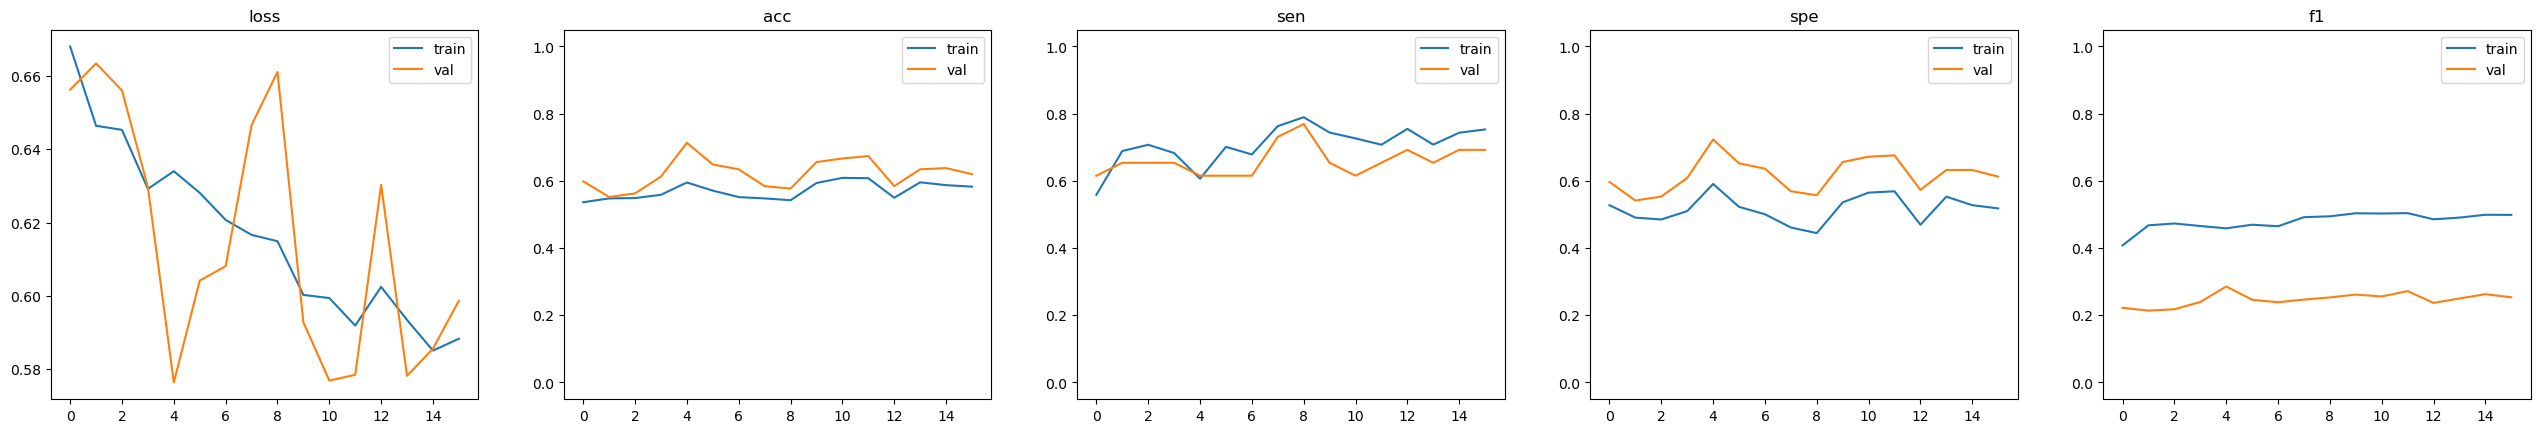

 ------------ Partition 4: ------------
Training ...
EARLY STOPPING. Metric = 'val_loss'. Patience = 10. Tolerance = 0.01.
STORING BEST MODEL FOR 'val_loss' AT ../results/experiment_example/partition_4/best_model_params.pt .


Training Progress:   0%|          | 0/50 [00:00<?, ?epoch/s]

,train_loss,train_acc,train_sen,train_spe,train_f1,train_cm,val_loss,val_acc,val_sen,val_spe,val_f1,val_cm,epoch_time
0,0.665331,0.577416,0.550000,0.588398,0.426756,"[[852, 596], [261, 319]]",0.650147,0.597122,0.32,0.624506,0.125000,"[[158, 95], [17, 8]]",13.119762
1,0.649839,0.518738,0.721368,0.436590,0.463736,"[[630, 813], [163, 422]]",0.700066,0.521583,0.72,0.501976,0.213018,"[[127, 126], [7, 18]]",13.133242
2,0.644950,0.527120,0.745267,0.439530,0.474521,"[[636, 811], [148, 433]]",0.694626,0.539568,0.72,0.521739,0.219512,"[[132, 121], [7, 18]]",13.006945
3,0.636110,0.587771,0.621716,0.574468,0.459250,"[[837, 620], [216, 355]]",0.623694,0.654676,0.44,0.675889,0.186441,"[[171, 82], [14, 11]]",13.023876
4,0.633743,0.606509,0.550523,0.628611,0.441958,"[[914, 540], [258, 316]]",0.587564,0.690647,0.44,0.715415,0.203704,"[[181, 72], [14, 11]]",13.077987
5,0.623433,0.607988,0.608379,0.607843,0.456596,"[[899, 580], [215, 334]]",0.606375,0.683453,0.56,0.695652,0.241379,"[[176, 77], [11, 14]]",12.866592
6,0.616567,0.582347,0.652921,0.553942,0.472931,"[[801, 645], [202, 380]]",0.620674,0.661871,0.56,0.671937,0.229508,"[[170, 83], [11, 14]]",12.715532
7,0.619106,0.563116,0.692440,0.511065,0.476359,"[[739, 707], [179, 403]]",0.646848,0.629496,0.68,0.624506,0.248175,"[[158, 95], [8, 17]]",12.489840
8,0.611569,0.582347,0.744348,0.518238,0.502642,"[[753, 700], [147, 428]]",0.646913,0.633094,0.68,0.628458,0.250000,"[[159, 94], [8, 17]]",12.608374
9,0.601479,0.610454,0.679715,0.583902,0.491634,"[[856, 610], [180, 382]]",0.593605,0.705036,0.64,0.711462,0.280702,"[[180, 73], [9, 16]]",12.811956


TRAINING STOPED BY EARLY-STOPPING AT EPOCH 15. NO SIGNIFICANT IMPORVEMENT (tolerance=0.01) ON 'val_loss' SINCE EPOCH 4.
LOADED BEST MODEL FOR 'val_loss' FOUND AT EPOCH 14 FROM ../results/experiment_example/partition_4/best_model_params.pt .


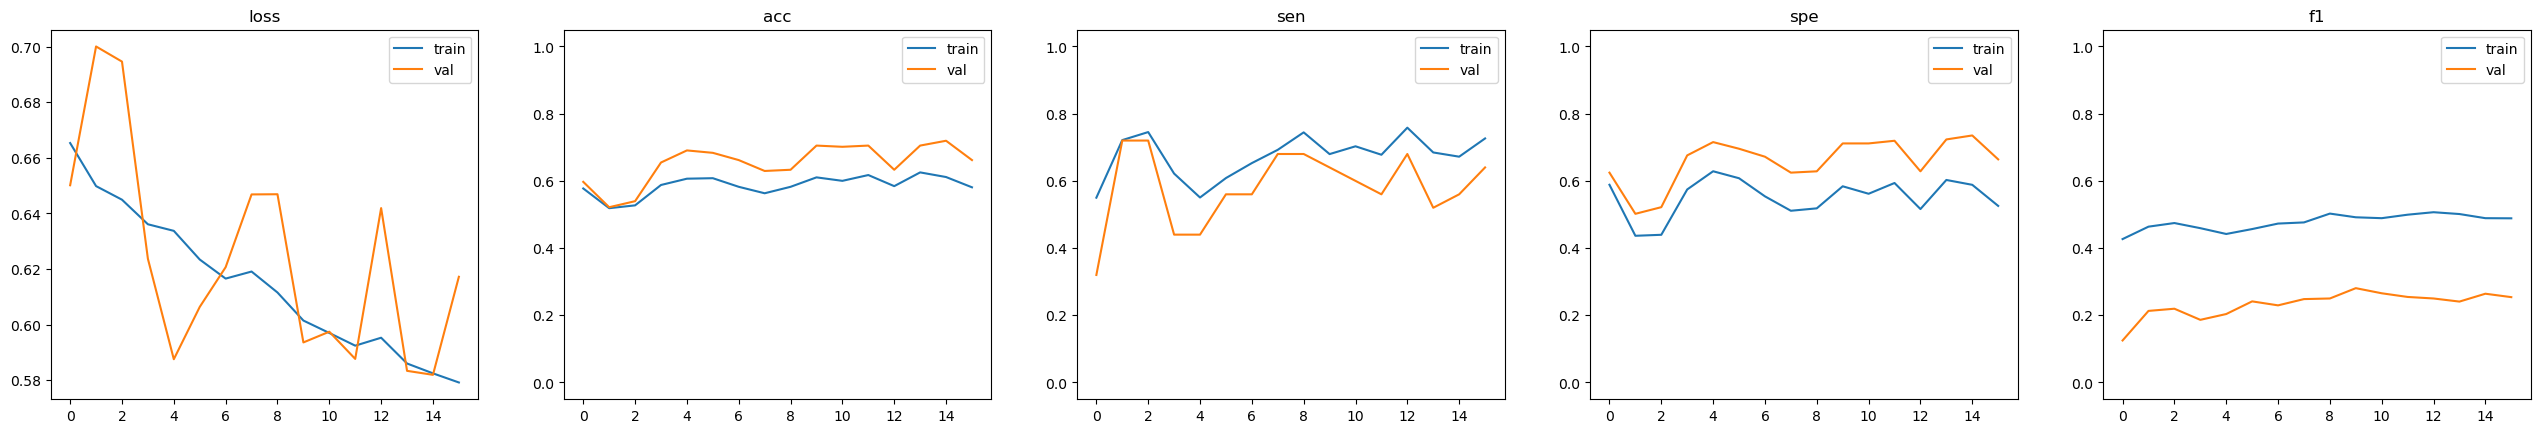

In [122]:
for k, (train_idxs_for_k, val_idxs_for_k) in enumerate(zip(train_idxs[:], val_idxs[:])):
    # Set training and validaiton samples for every partition
    print(f" ------------ Partition {k}: ------------")
    train_dataset = torch.utils.data.Subset(ram_dataset, train_idxs_for_k)
    val_dataset = torch.utils.data.Subset(ram_dataset, val_idxs_for_k)
    dataloaders = {
            'train':DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
            'val':DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        }
    print(f"Training ...")

    # Reset model for every partition
    reproducibility(seed=torch_seed) # Batching
    resnet.load_state_dict(torch.load(f'{exp_results_dir_path}/initial_values.pt')) # Initial values
    optimizer = torch.optim.Adam(
        [
            {"params": resnet.fc_head.parameters(), "lr": lr},
        ],
    )
    # Training
    res = utilities.train.train(
            model = resnet,
            optimizer = optimizer,
            loss = loss,
            n_epochs = 50,
            dataloaders = dataloaders,
            metrics = metrics,
            data_augmentation_t = data_augmentation_t,
            mixup_t = mixup_t,
            es_patience = es_patience,
            es_tolerance = es_tolerance,
            es_metric = es_metric,
            best_model_save_load = True,
            bm_metric = bm_metric,
            results_dir_path=f'{exp_results_dir_path}/partition_{k}',
            verbosity = 1,
        )

It is worth mentioning that during the actual experimentation of the project, intead of using the early stopping and best model functionalities built into the `train` function, all models were trained for 50 epochs, the selection of the best model was done afterwards using the value of every metric per epoch. Why? Because except for the testing phase (where the best model functionality was used), loading the best model after the training finished (or storing it's weight for future use) wasn't needed. For most experiments, only the train/validation performance of the model during training was needed.

# 4. Evaluation

To evaluate a candidate (a model and it's parameters), cross-validaiton (k=5) performance must be computed. To compute cross-validation performance, the performance of the best model of each fold/itearation is selected. Then, for every metric, the mean of the 5 performances is computed. 

To choose this best model, in this case we use the same used during training, because in some cases it affected the training (early stopping), so now it would not be fair to change the criteria. However, as said at the end of the last section, when not using ealry stopping, the selection of the best model per iteration/split can be done afterwards, instead of repeating the experiment for every criteria.

In [151]:
from utilities.common import M
# Metrics to recap
col_names = []
for cjto in ['train', 'val']:
    for m in ['loss', 'acc', 'sen', 'spe', 'f1']:
        col_names.append(f"{cjto}_{m}")
# Varibale to store the value of he best metric for every iteration
metrics_best_model_per_iter = {}
metrics_best_model_per_iter['epoch'] = []
for m in col_names:
    metrics_best_model_per_iter[m] = []
# For every iteration/split of the cross validation process
for k in range(5):
    # Performance per metric
    iter_results = pd.read_csv(f"{exp_results_dir_path}/partition_{k}/results.csv", usecols=col_names, index_col=False)
    # Epoch where the best model is found
    epoch_best = np.argmax(iter_results['val_acc'].to_numpy()) # Epoch = Row of best model
    # Collect best model performance
    metrics_best_model_per_iter['epoch'].append(epoch_best)
    for c_n in col_names:
        metrics_best_model_per_iter[c_n].append(iter_results.loc[epoch_best][c_n])
metrics_best_model_per_iter = pd.DataFrame(metrics_best_model_per_iter)
metrics_best_model_per_iter

,epoch,train_loss,train_acc,train_sen,train_spe,train_f1,val_loss,val_acc,val_sen,val_spe,val_f1
0,15,0.578433,0.622902,0.640981,0.615808,0.489305,0.527897,0.756272,0.480000,0.783465,0.260870
1,15,0.577098,0.639191,0.647986,0.635739,0.503059,0.547795,0.759857,0.520000,0.783465,0.279570
2,41,0.525126,0.673570,0.673145,0.673735,0.535112,0.473543,0.820789,0.576923,0.845850,0.375000
3,4,0.634013,0.595168,0.606272,0.590784,0.458800,0.576368,0.713262,0.615385,0.723320,0.285714
4,14,0.582484,0.611440,0.672014,0.588275,0.488975,0.581950,0.719424,0.560000,0.735178,0.264151


In [153]:
# Mean and stds
means = np.array(metrics_best_model_per_iter[col_names]).mean(axis=0)
stds = np.array(metrics_best_model_per_iter[col_names]).std(axis=0)
row_indexes = ['mean', 'std']
pd_means_stds = pd.DataFrame([means,stds], columns=col_names, index=row_indexes)
pd_means_stds

,train_loss,train_acc,train_sen,train_spe,train_f1,val_loss,val_acc,val_sen,val_spe,val_f1
mean,0.579431,0.628454,0.648080,0.620868,0.495050,0.541511,0.753921,0.550462,0.774255,0.293061
std,0.034479,0.026754,0.024493,0.031651,0.024711,0.039230,0.038354,0.046688,0.043398,0.042005
